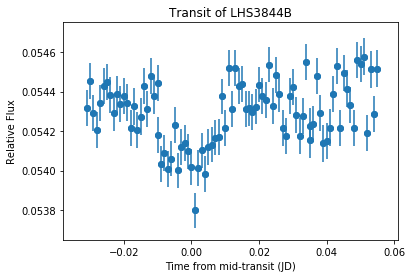

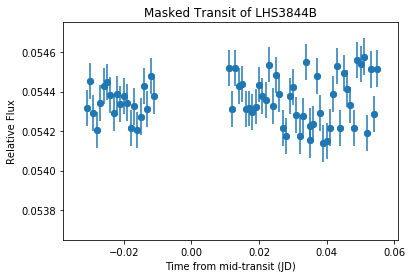

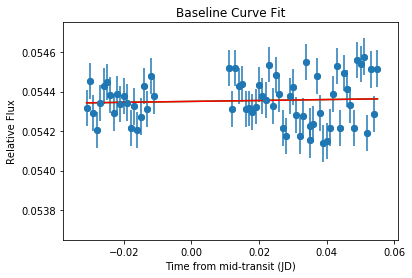

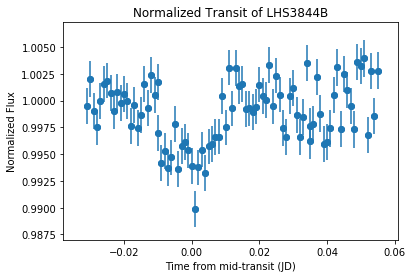

In [1]:
%matplotlib inline 
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from astropy.io import ascii
from astropy.table import Table, Column
import os
import sys
import batman

def Lightcurve_Preparation(filename, planet, epoch, startOfTransit, lengthOfTransit):
    data = pandas.read_csv('/Users/sarahtang/Downloads/SRS 2019/TESSredo.csv') #read in a .csv file 
    flux = data['rel_flux_T1'] 
    JD = data['JD_UTC'] 
    date = JD - epoch #epoch is the JD for the planet's date of discovery
    error = data['rel_flux_err_T1'] 
    plt.figure() 
    plt.scatter(date,flux) 
    plt.errorbar(date,flux,yerr=error,fmt='o') 
    plt.title('Transit of LHS3844B')
    plt.xlabel('Time from mid-transit (JD)')
    plt.ylabel('Relative Flux') #unitless
    plt.xlim([-0.038, 0.061])
    plt.ylim([0.05365, 0.05475])
    plt.show()

    
    
    #mask the transit
    high = startOfTransit + lengthOfTransit 
    mask = np.where(np.logical_not((date >= startOfTransit)& (date <= high)))[0] 
    plt.figure()
    plt.scatter(date[mask],flux[mask]) 
    plt.errorbar(date[mask],flux[mask],yerr=error[mask],fmt='o') 
    plt.title('Masked Transit of LHS3844B')
    plt.xlabel('Time from mid-transit (JD)')
    plt.ylabel('Relative Flux') #unitless
    plt.xlim([-0.038, 0.061])
    plt.ylim([0.05365, 0.05475])
    plt.show()

    #fit a line to the baseline flux
    def f_x(x,a,b):
        return a + b*x
    popt, pcov = curve_fit(f_x,date[mask],flux[mask])
    poly = f_x(date[mask], *popt)
    baseline_fit = f_x(date, *popt) 
    plt.plot(date[mask],poly,color='green',label='Power-Law') 
    plt.plot(date,baseline_fit,color='red') 
    plt.scatter(date[mask],flux[mask]) 
    plt.errorbar(date[mask],flux[mask],yerr=error[mask],fmt='o') 
    plt.title('Baseline Curve Fit')
    plt.xlabel('Time from mid-transit (JD)')
    plt.ylabel('Relative Flux') #unitless
    plt.xlim([-0.038, 0.061])
    plt.ylim([0.05365, 0.05475])
    plt.show()
    
    #normalize the transit light curve graph
    normed_flux = flux/baseline_fit
    normed_err = error/baseline_fit
    plt.scatter(date,normed_flux)
    plt.errorbar(date,normed_flux,yerr=normed_err,fmt='o')
    plt.title('Normalized Transit of LHS3844B')
    plt.xlabel('Time from mid-transit (JD)')
    plt.ylabel('Normalized Flux') #unitless
    plt.xlim([-0.038, 0.061])
    plt.ylim([0.987, 1.0073])
    
    dat = Table([normed_flux,normed_err,JD], names=['Flux','error','JD']) #store the normalized data in a text file
    ascii.write(dat, '/Users/sarahtang/Downloads/SRS 2019/normalizedLHS3844B.txt',overwrite=True)

Lightcurve_Preparation(filename = '/Users/sarahtang/Downloads/SRS 2019/TESSredo.csv',
                       planet = 'TESS Candidate', epoch = 2458372.478,
                       startOfTransit = -0.01, lengthOfTransit = 0.02)


The following code cell is primarily useful for learning how to do the following things: 

1) Fit a best-fit model to the normalized transit light curve 
2) Perform a chi-squared goodness of fit test on the data to find the best-fit model 
3) Calculate the planet's normalized radius (Rp/R*) and relative time of mid-transit from the model 
4) Create a chi-squared map to find the 1σ error bar ranges for all light curve calculations

Best-fit Radius:  [0.06706707]
Best-fit mid-transit time:  [-0.08708709]


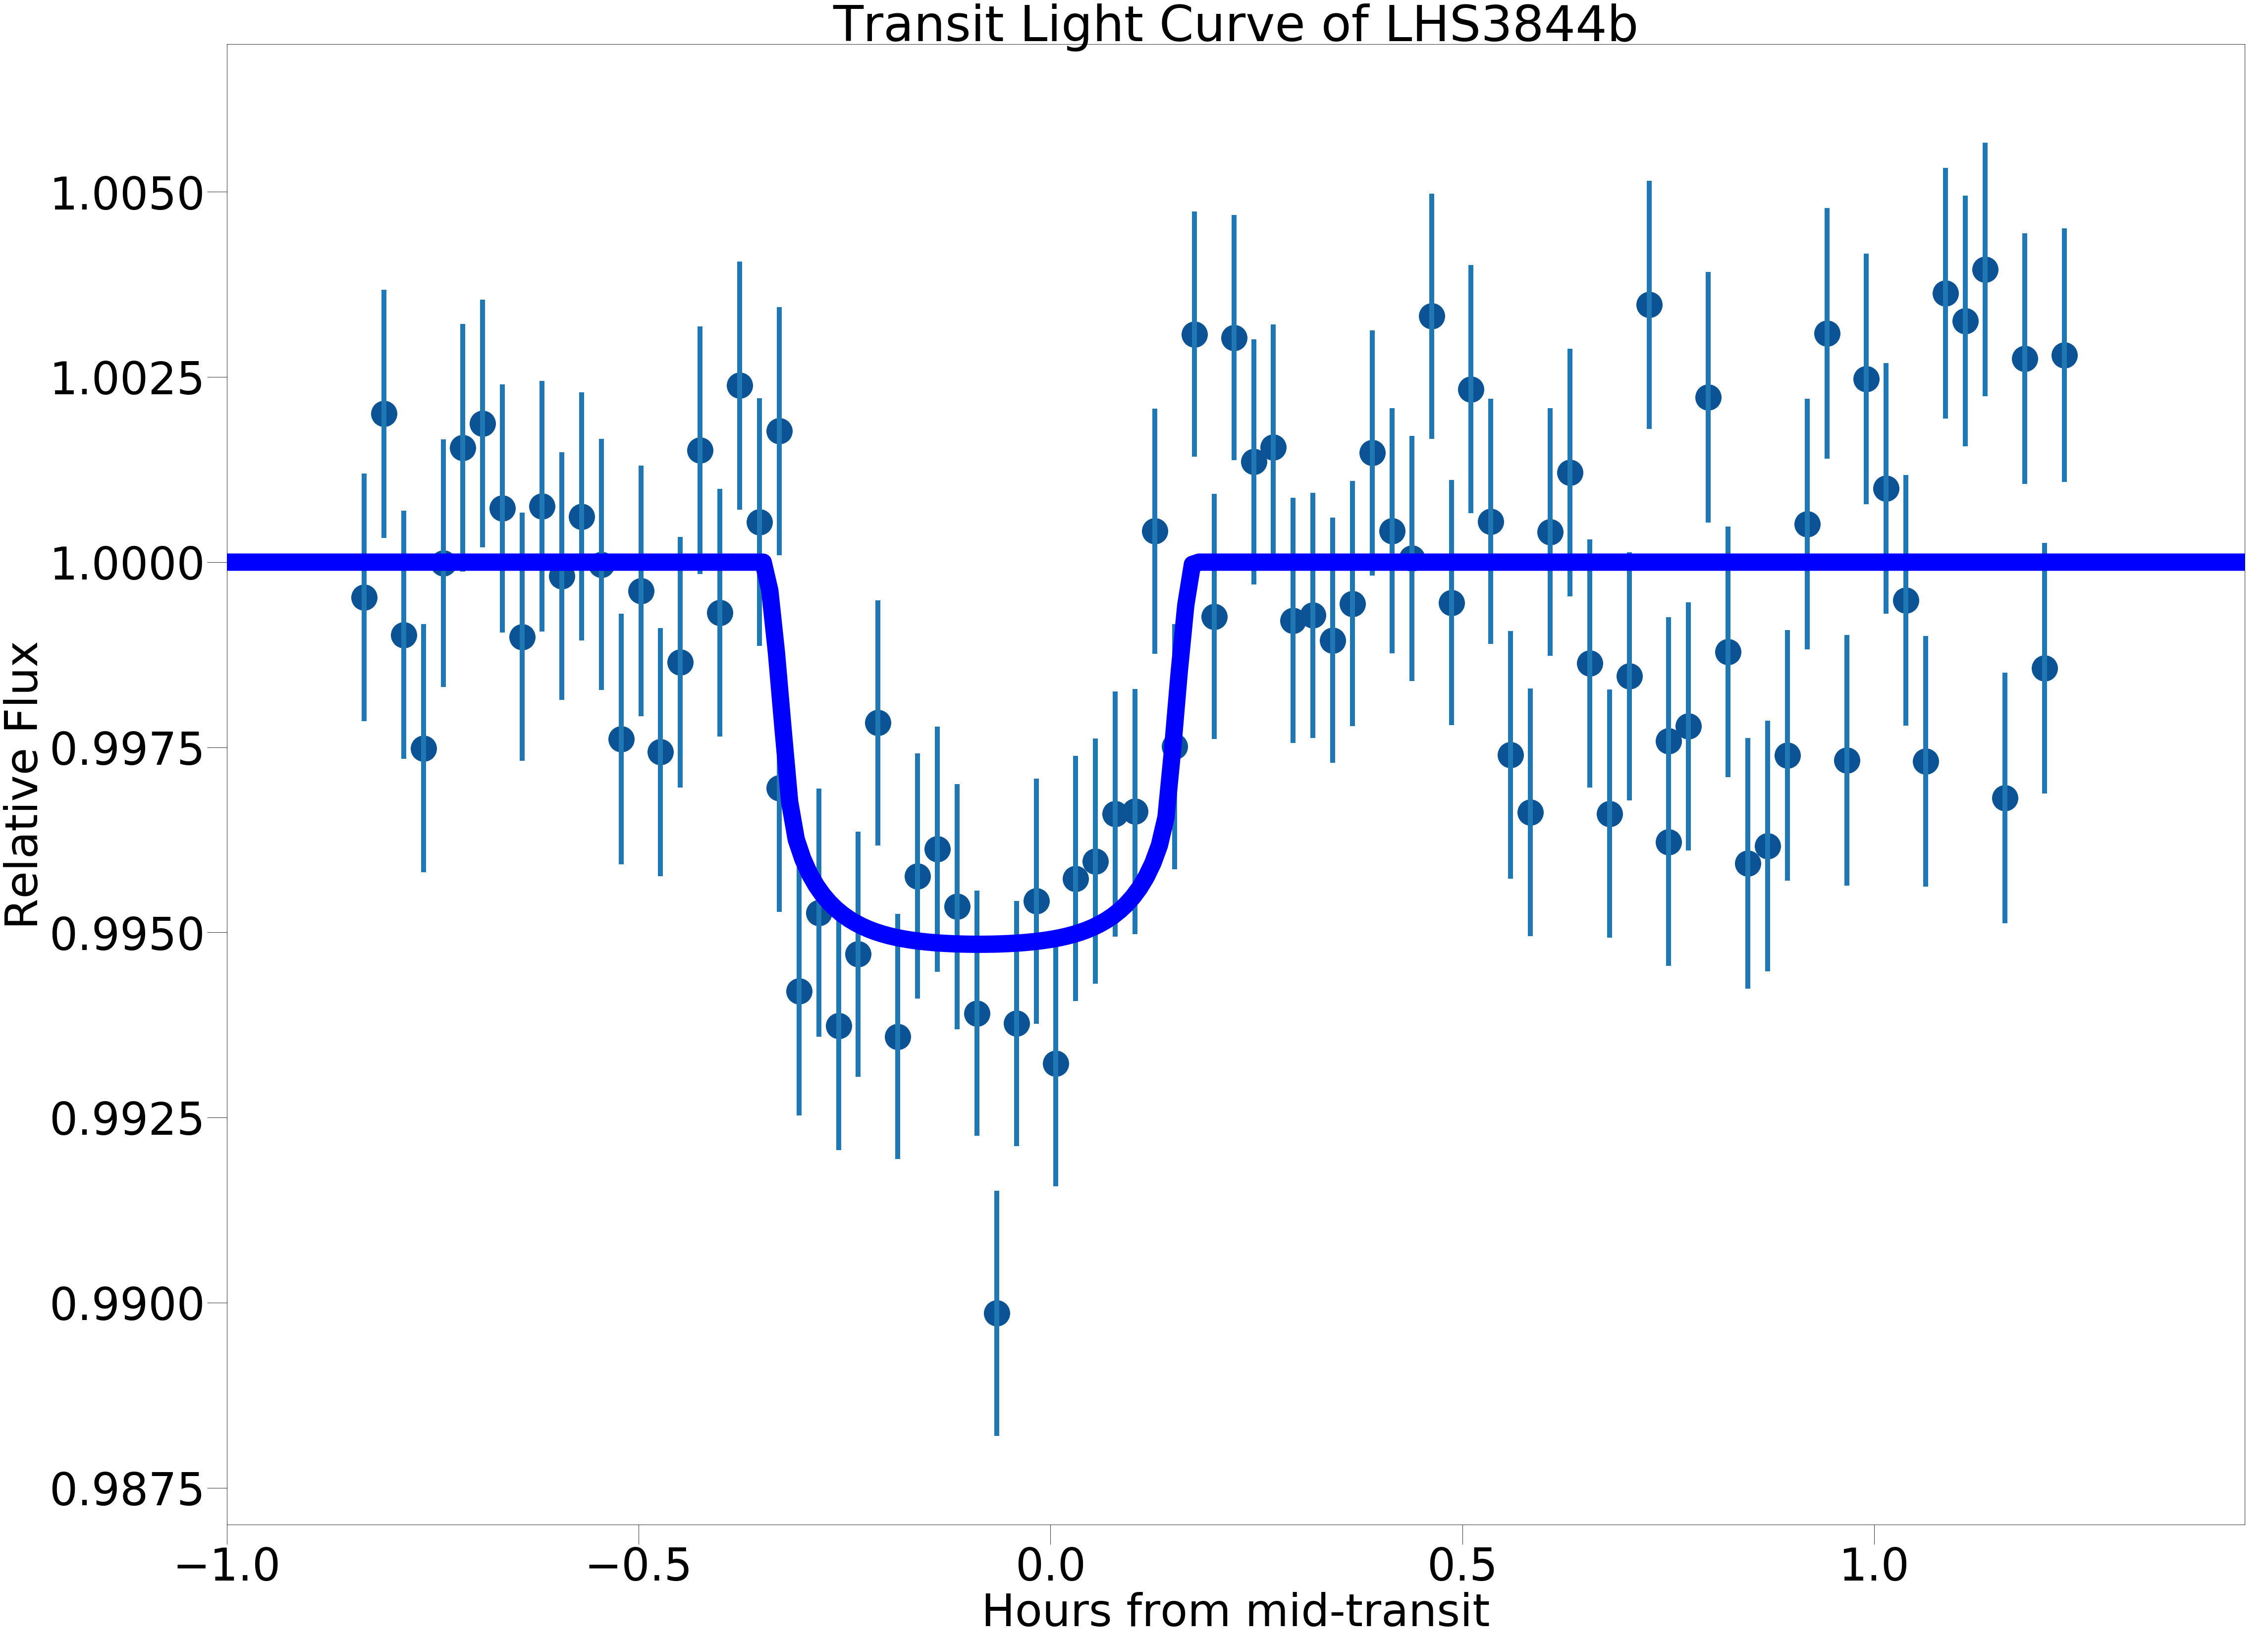

this here
[[3.43427788e+00 3.43427788e+00 3.43427788e+00 ... 3.43427788e+00
  3.43427788e+00 3.43427788e+00]
 [3.43427019e+00 3.43426953e+00 3.43426889e+00 ... 3.43428379e+00
  3.43428480e+00 3.43428577e+00]
 [3.43424645e+00 3.43424343e+00 3.43424094e+00 ... 3.43430338e+00
  3.43430722e+00 3.43431091e+00]
 ...
 [5.39150930e+03 5.51554261e+03 5.64155508e+03 ... 4.03474516e+04
  4.02821269e+04 4.02158489e+04]
 [5.41048552e+03 5.53485116e+03 5.66119934e+03 ... 4.04461206e+04
  4.03805756e+04 4.03140745e+04]
 [5.42950717e+03 5.55420551e+03 5.68088980e+03 ... 4.05448409e+04
  4.04790751e+04 4.04123506e+04]]


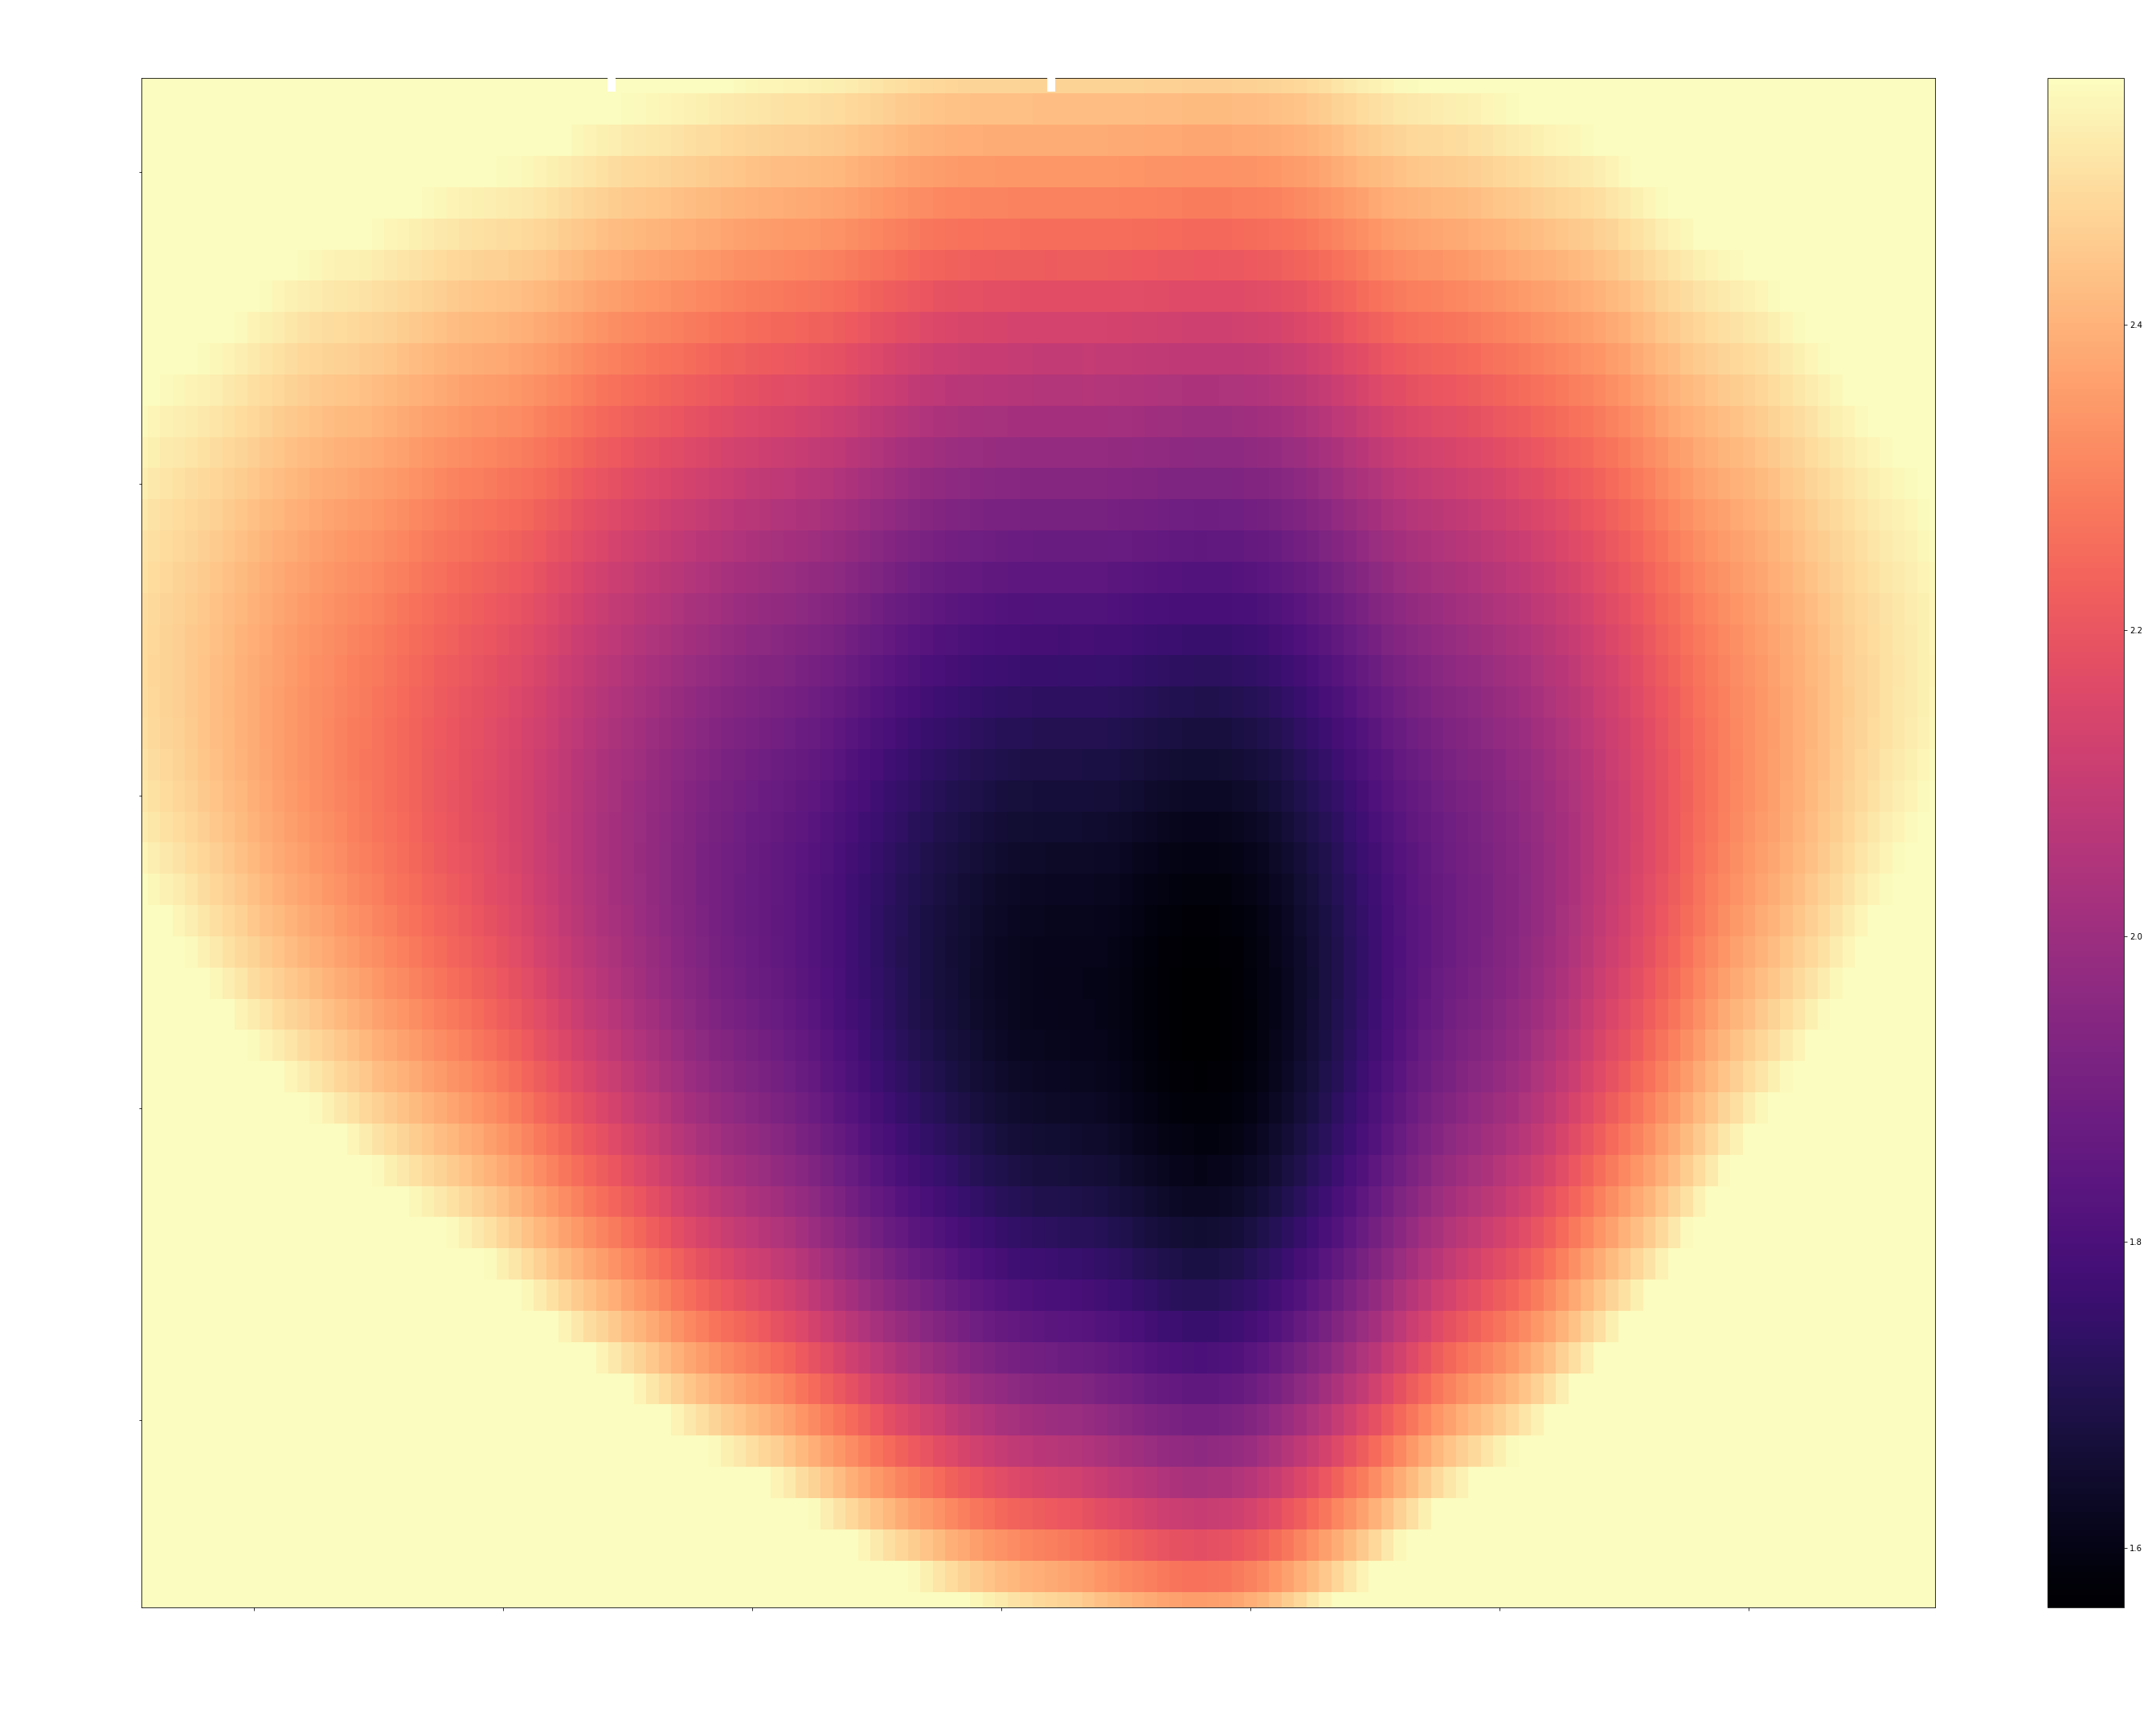

min reduced chi2:  1.5610315086627977
[0.17017017] [0.11811812]
[0.03003003] [0.01901902]


<Figure size 432x288 with 0 Axes>

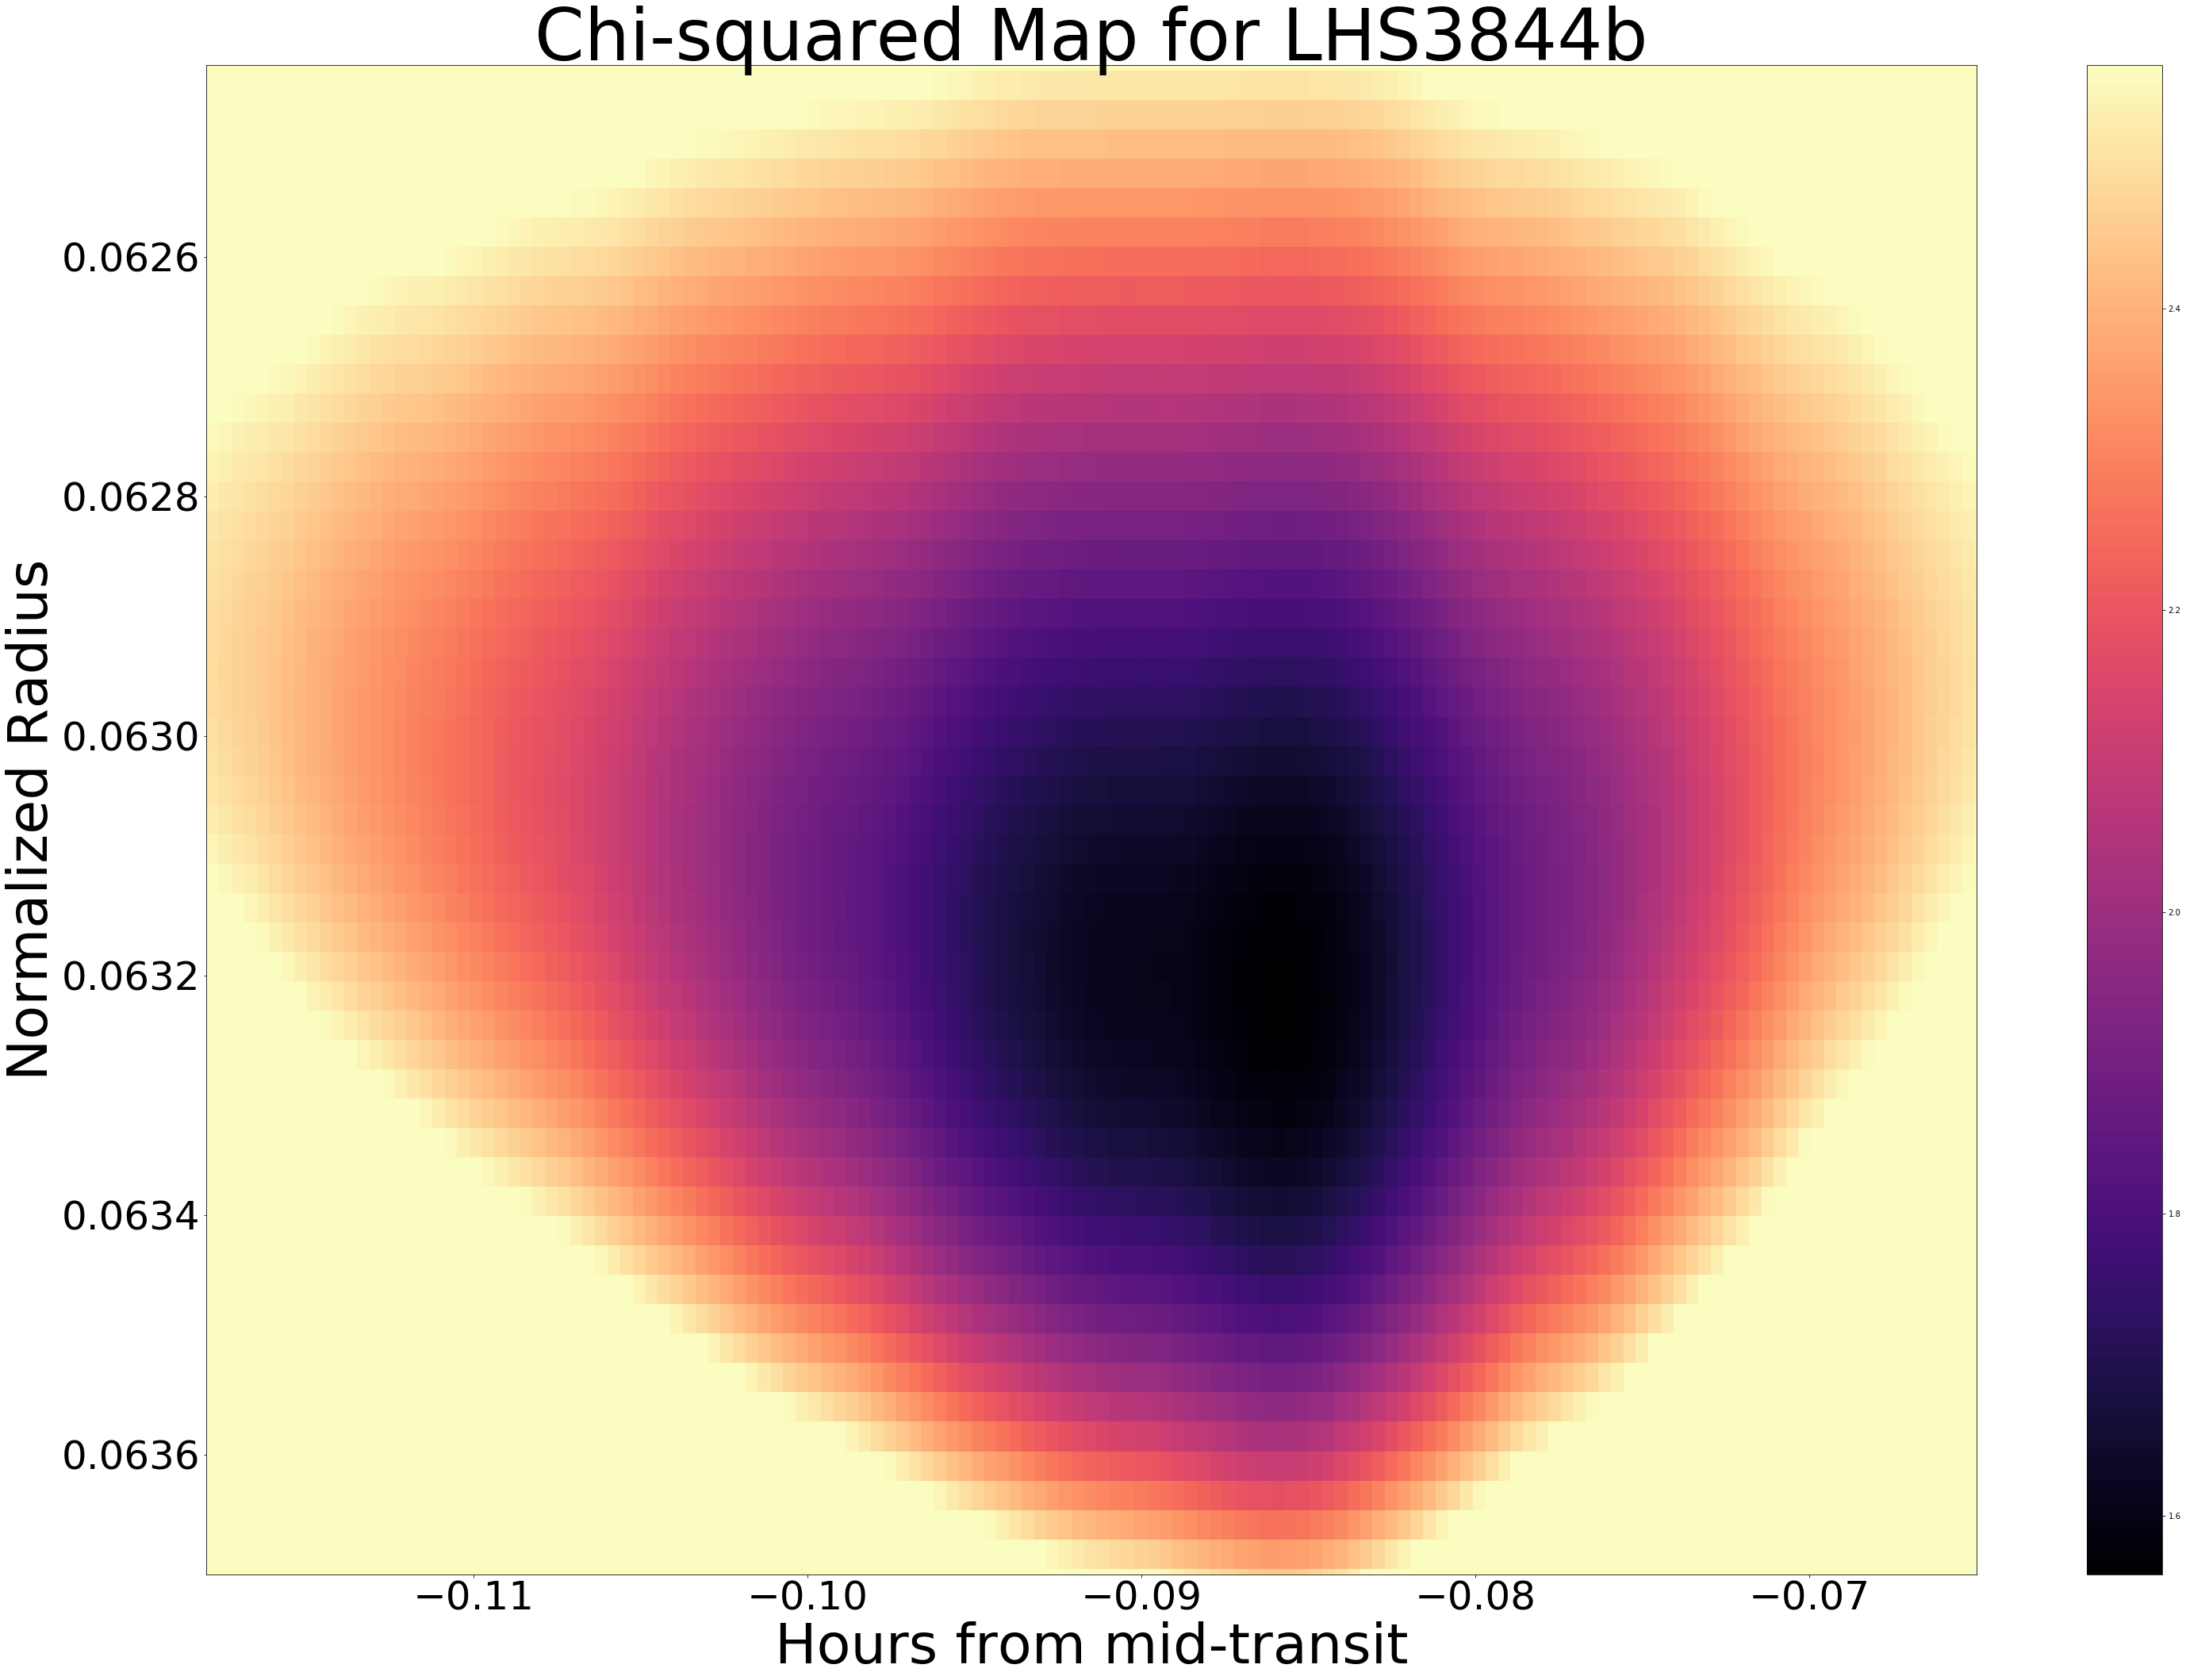

<Figure size 432x288 with 0 Axes>

In [3]:
import os
import sys
import batman
import numpy as np
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import ascii
import numpy as np
from pylab import *
from scipy import *
import scipy.constants as const
from scipy import optimize

data = astropy.io.ascii.read('/Users/sarahtang/Downloads/SRS/normalizedLHS3844B.txt')
flux = data['Flux']
error = data['error']
JD = data['JD']
def BATMAN_MODEL(rp, t0, period, inc, u, time_array):
    params = batman.TransitParams()
    params.rp = rp
    params.t0 = t0
    params.per = period
    params.inc = inc
    params.u = u
    params.a = 7.1059
    params.ecc = 0.0
    params.w = 0.0
    params.limb_dark = "quadratic"
    
    
    m = batman.TransitModel(params, time_array)
    flux = m.light_curve(params)
    return flux

per = 0.46292792 
JD_t0 = 2458325.726
Norbits = np.array((JD-JD_t0)/per)
hr_mid = (Norbits-101.0)*per*24.0

times = np.linspace(-2, 2, 500)
model = BATMAN_MODEL(rp=0.0640, t0=0, period=per*24, inc=88.22, u=[0.13,0.53],time_array=times)

c = 500
t = np.linspace(-3, 4, 500)
radius = np.linspace(0.0, 1.0, 1000)
midtransit = np.linspace(-1, 1, 1000)

chi2 = np.zeros(shape=(len(data['Flux']),len(radius),len(midtransit)))

for k in range(len(radius)):
    for j in range(len(midtransit)):
        
        model = BATMAN_MODEL(rp=radius[k], t0=midtransit[j], period=per*24, inc=88.22,
                             u=[0.13,0.53],time_array=hr_mid)
        
        for i in range(len(data['Flux'])):
            z = (flux[i] - model[i]) / error[i]
            chi2[i,k,j] = z**2.0
            
chi2sum = np.sum(chi2, axis = 0)
chi2_min = np.amin(chi2sum)
indices = np.where(chi2sum == chi2_min)
best_rad = indices[0]
best_t0 = indices[1]

print("Best-fit Radius: ", radius[best_rad])
print("Best-fit mid-transit time: ",midtransit[best_t0])

best_model = BATMAN_MODEL(rp=radius[best_rad], t0=midtransit[best_t0],
                          period=per*24, inc=88.22, u=[0.13,0.53],time_array=times)

# with the best-fit model
fig = plt.figure(figsize=(73, 55))
ax = fig.add_subplot(111)
#ax.set_facecolor("#9594abff")
ax.scatter(hr_mid, flux, s=2700, color="#0b5394ff")
ax.errorbar(hr_mid, flux,yerr = error, fmt = 'o', elinewidth=10)
ax.plot(times, best_model,zorder=100,linewidth=35, c='blue')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis='x', colors='black', size=40)
ax.tick_params(axis='y', colors='black', size=40)
plt.xticks(fontsize=90)
plt.yticks(fontsize=90)
plt.title('Transit Light Curve of LHS3844b', color="black", fontsize=100)
plt.xlabel('Hours from mid-transit', color='black', fontsize=90)
plt.xlim(-1.0, 1.45)
plt.ylim(0.987, 1.007)
plt.ylabel('Relative Flux', color="black", fontsize=90)
plt.show()

# chi-squared map
plt.figure(figsize=(50, 35))
ax = fig.add_subplot(111)
plt.imshow(chi2sum/len(data), vmax=chi2_min/len(data)+1, aspect='auto', cmap="magma")
print("this here")
print(chi2sum/len(data))
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white', size=60)
ax.tick_params(axis='y', colors='white', size=60)
plt.xticks(fontsize=55, color="white")
plt.yticks(fontsize=55, color="white")
plt.xlim(371, 515)
plt.ylim(86, 37)
plt.xlabel('Hours from mid-transit', color="white", fontsize=90)
plt.ylabel('Normalized Radius', color="white", fontsize=90)
plt.title("Chi-squared Map for LHS3844B", color="white", fontsize=110)
plt.colorbar()
plt.show()
plt.clf()

print ("min reduced chi2: ", chi2_min/len(data))
print(midtransit[best_t0]-midtransit[371], midtransit[515]-midtransit[best_t0])
print(radius[best_rad]-radius[37], -radius[best_rad]+radius[86])

# final chi-squared map MAGMA
plt.figure(figsize=(50, 35))
ax = fig.add_subplot(111)
plt.imshow(chi2sum/len(data), vmax=chi2_min/len(data)+1, origin='upper', extent=(midtransit[371], midtransit[515]-midtransit[best_t0], radius[86], (radius[86]+radius[37])/2), 
           aspect='auto', cmap="magma")
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis='x', colors='black', size=80)
ax.tick_params(axis='y', colors='black', size=80)
plt.xticks(fontsize=50, color="black")
plt.yticks(fontsize=50, color="black")
plt.xlim(-0.118, -0.065)
plt.ylim(0.0637, 0.06244)
plt.xlabel('Hours from mid-transit', color="black", fontsize=70)
plt.ylabel('Normalized Radius', color="black", fontsize=70)
plt.title("Chi-squared Map for LHS3844b", color="black", fontsize=90)
plt.colorbar()
plt.show()
plt.clf()